In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import utils_plots as ut

/opt/miniconda3/envs/tf_tcg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'tcg_fsM')

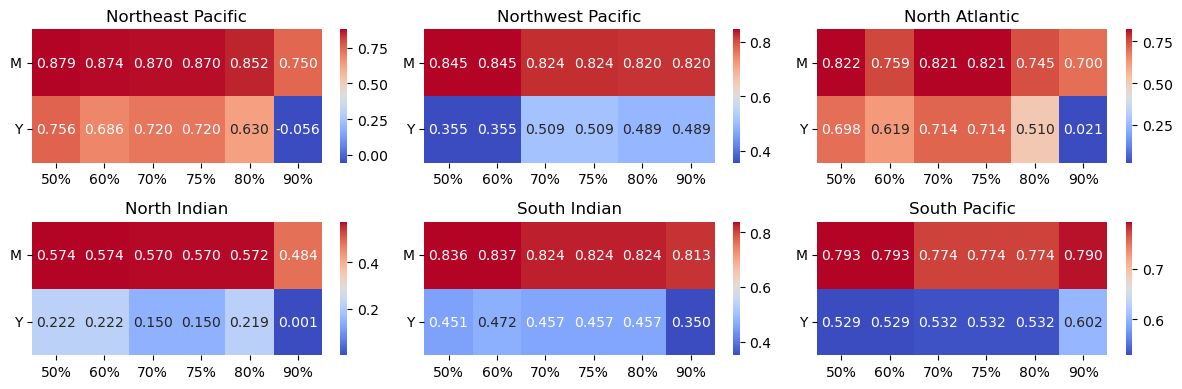

In [ ]:
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(2, 3, figure=fig)
count = 0
for basin, (basin_name, n_clusters) in basin_dict.items():
    run_names = [f'selfeat50_top20_nc{n_clusters}_nv8_nd9', f'selfeat60_top20_nc{n_clusters}_nv8_nd9', f'selfeat70_top20_nc{n_clusters}_nv8_nd9', 
                 f'selfeat75_top20_nc{n_clusters}_nv8_nd9', f'selfeat80_top20_nc{n_clusters}_nv8_nd9', f'selfeat90_top20_nc{n_clusters}_nv8_nd9']
    col_perc = [run.split('_')[0].split('feat')[1] for run in run_names]
    df_corr = pd.DataFrame(0.0, index=['rM', 'rY'], columns=col_perc)
    df_mse = pd.DataFrame(0.0, index=['mseM', 'mseY'], columns=col_perc)
    for run_name in run_names:
        # Get the folder containing the cluster data
        cluster_data = f'{basin}_{n_clusters}clusters'
        target_file = 'target_1980-2022_2.5x2.5.csv'
        cluster_data_dir = os.path.join(fs_dir, 'data', cluster_data)
        # target
        target_df = pd.read_csv(os.path.join(cluster_data_dir, target_file), index_col=0)
        target_df.index = pd.to_datetime(target_df.index)
        target_df = target_df.loc[target_df.index.year.isin(years)]
        # Get the run info and data
        Y_pred, Y_pred_noFS, X_test_eval, X_test_eval_noFS, mlps, mlps_noFS, shap_values_mlp = ut.runs_info(basin, run_name, project_dir, years)
        # Convert list of dataframes to a single dataframe
        X_test = pd.concat(X_test_eval)
        X_test_noFS = pd.concat(X_test_eval_noFS)
        Y_pred_df = pd.concat(Y_pred)
        Y_pred_noFS_df = pd.concat(Y_pred_noFS)
        # Annual data without trend and seasonality
        target_df_annual = target_df.groupby(target_df.index.year).sum()
        Y_pred_df_annual = Y_pred_df.groupby(Y_pred_df.index.year).sum()
        Y_pred_noFS_df_annual = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.year).sum()
        # Compute the correlation coefficient and the MSE between the predictions and the test values
        # Monthly without trend and seasonality
        r, _ = pearsonr(target_df['tcg'], Y_pred_df['tcg'])
        mse = mean_squared_error(target_df['tcg'], Y_pred_df['tcg'])
        # Annual without trend and seasonality
        rY, _ = pearsonr(target_df_annual['tcg'], Y_pred_df_annual['tcg'])
        mseY = mean_squared_error(target_df_annual['tcg'], Y_pred_df_annual['tcg'])
        # Store the results
        perc = run_name.split('_')[0].split('feat')[1]
        df_corr.loc['rM', perc] = r
        df_corr.loc['rY', perc] = rY
        df_mse.loc['mseM', perc] = mse
        df_mse.loc['mseY', perc] = mseY
    # Plot the results
    ax = fig.add_subplot(gs[count])
    sns.heatmap(df_corr, annot=True, fmt=".3f", cmap='coolwarm', ax=ax)
    ax.set_title(basin_name)
    xtick_labels = ['50%', '60%', '70%', '75%', '80%', '90%']
    ax.set_xticks(np.arange(len(xtick_labels), dtype=float)+0.5)
    ax.set_xticklabels(xtick_labels)
    ax.set_yticks(np.arange(2, dtype=float)+0.5)
    ax.set_yticklabels(['M', 'Y'], rotation=0)
    plt.tight_layout()
    count += 1
plt.show()
fig.savefig(os.path.join(fs_dir, 'best_model_analysis', 'figures', 'sensitivity_analysis.pdf'), format='pdf', bbox_inches='tight', dpi=300)